In [1]:
from alexnet_model import AlexNet
from CP_N_Way_Decomposition import CP_ALS
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import OrderedDict

In [2]:
model = AlexNet()
print(model.features[3])
print(model.eval())
path = './exp1/checkpoint.pth.tar'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
model.load_state_dict(checkpoint['state_dict'])

Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096

<All keys matched successfully>

In [3]:
def read_image(image_path):
    image = np.array(plt.imread(image_path))
    torch_ip_tensor = torch.from_numpy(image).T
    torch_ip_tensor = torch_ip_tensor.unsqueeze(0)
    return torch_ip_tensor

In [61]:
torch_image = read_image("6221.jpg")
print(torch_image.shape)
print(type(torch_image))

torch.Size([1, 3, 460, 460])
<class 'torch.Tensor'>


In [62]:
img_1 = model.features[2](model.features[1](model.features[0](torch_image.float())))
print(img_1.shape)

torch.Size([1, 64, 231, 231])


In [63]:
org_op_image = model.features[3](img_1).squeeze(0)
print(org_op_image.shape)

torch.Size([192, 231, 231])


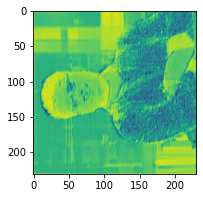

In [96]:
image_org = org_op_image.detach().numpy()
plt.figure(figsize=(3, 3))
plt.imshow(image_org[1, :, :])
plt.show()

In [70]:
def replace_layer(weight_tensor):
    max_iter = 60
    rank = 6
    cp = CP_ALS()
    print()
    print("Rank is : ", rank)
    print("Computing the factors of the weight tensor", flush=True)
    start = time.time()
    A, lmbds = cp.compute_ALS(weight_tensor, max_iter, rank)
    end = time.time()
    print("Factors calculated in ", end-start," seconds", flush=True)
    K_t, K_s, K_y, K_x = A[0], A[1], A[2], A[3]
    print(K_t.shape, K_s.shape, K_y.shape, K_x.shape)
    K_s_a = K_s.T.unsqueeze(-1).unsqueeze(-1)
    K_y_a = K_y.T.unsqueeze(1).unsqueeze(0)
    K_x_a = K_x.T.unsqueeze(1).unsqueeze(-1)
    K_t_a = K_t.unsqueeze(-1).unsqueeze(-1)
    K_s = K_s.unsqueeze(-1).unsqueeze(-1)
    K_y = K_y.T.unsqueeze(1).unsqueeze(1)
    K_x = K_x.T.unsqueeze(0).unsqueeze(-1)
    K_t = K_t.T.unsqueeze(-1).unsqueeze(-1)
    model = torch.nn.Sequential(OrderedDict([
            ('K_s', torch.nn.Conv2d(K_s.shape[0], K_s.shape[1], kernel_size = (K_s.shape[2], K_s.shape[3]),  padding = (0, 0))),
            ('K_y', torch.nn.Conv2d(K_y.shape[0], K_y.shape[1], kernel_size = (K_y.shape[2], K_y.shape[3]),  padding = (0, 0))),
            ('K_x', torch.nn.Conv2d(K_x.shape[0], K_x.shape[1], kernel_size = (K_x.shape[2], K_x.shape[3]),  padding = (0, 0))),
            ('K_t', torch.nn.Conv2d(K_t.shape[0], K_t.shape[1], kernel_size = (K_t.shape[2], K_t.shape[3]),  padding = (1, 1)))
            ]))
    #with torch.no_grad():
    print("Layer shape: ")
    print(K_s.shape, K_y.shape, K_x.shape, K_t.shape)
    print("Input shape: ")
    print(K_s_a.shape, K_y_a.shape, K_x_a.shape, K_t_a.shape)
    model[0].weight = torch.nn.Parameter(K_s_a)
    model[1].weight = torch.nn.Parameter(K_y_a)
    model[2].weight = torch.nn.Parameter(K_x_a)
    model[3].weight = torch.nn.Parameter(K_t_a)
    return model


In [71]:
replace_model = replace_layer(model.features[3].weight.data)
print(replace_model)


Rank is :  6
Computing the factors of the weight tensor
Factors calculated in  25.689319610595703  seconds
torch.Size([192, 6]) torch.Size([64, 6]) torch.Size([3, 6]) torch.Size([3, 6])
Layer shape: 
torch.Size([64, 6, 1, 1]) torch.Size([6, 1, 1, 3]) torch.Size([1, 6, 3, 1]) torch.Size([6, 192, 1, 1])
Input shape: 
torch.Size([6, 64, 1, 1]) torch.Size([1, 6, 1, 3]) torch.Size([6, 1, 3, 1]) torch.Size([192, 6, 1, 1])
Sequential(
  (K_s): Conv2d(64, 6, kernel_size=(1, 1), stride=(1, 1))
  (K_y): Conv2d(6, 1, kernel_size=(1, 3), stride=(1, 1))
  (K_x): Conv2d(1, 6, kernel_size=(3, 1), stride=(1, 1))
  (K_t): Conv2d(6, 192, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
)


In [72]:
rpl_image = replace_model(img_1).squeeze(0)
print(img_1.shape)
print(rpl_image.shape)

torch.Size([1, 64, 231, 231])
torch.Size([192, 231, 231])


172


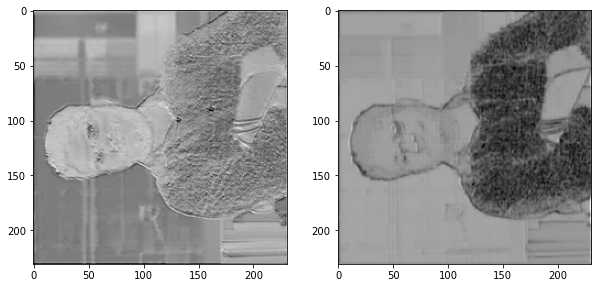

In [91]:
i = np.random.randint(0, rpl_image.size(0))
print(i)
image_rpl = rpl_image.detach().numpy()
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_org[i, :, :], "gray")
plt.subplot(1, 2, 2)
plt.imshow(image_rpl[i, :, :], "gray")
plt.show()

In [95]:
diff = image_org-image_rpl
fit_val = (np.linalg.norm(diff)**2)/(np.linalg.norm(image_org)**2)
print(fit_val)

4.376640410516849
